In [1]:
import glob
import os

import re
import PIL
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from keras.engine.saving import load_model
from other_models.metrics.scores import GlobalF1
from sklearn.metrics import f1_score

from other_models.img.processor import extract_data, extract_labels, read_img_file
from other_models.img.prediction import get_prediction_with_overlay, get_testing_prediction, \
    get_prediction_with_overlay_correctness, get_testing_prediction_overlay, get_prediction_concat
from other_models.models.data_augmentation import CenteredCropGenerator
%matplotlib inline

np.random.seed(2)

import time

from keras.models import Model
from keras.layers import Dropout, Conv2D
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping


sns.set(style='white', context='notebook', palette='deep')

Using TensorFlow backend.


In [2]:
# check if using cpu or gpu
from tensorflow.python.client import device_lib 


import tensorflow as tf
print(tf.__version__)


print(device_lib.list_local_devices())

2.0.0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1000724476273974512
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 10500839547241903428
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 9517908632424719263
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3546284032
locality {
  bus_id: 1
  links {
  }
}
incarnation: 18097991299679449874
physical_device_desc: "device: 0, name: GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [3]:
# train
# history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, 
#          validation_data = (X_val, Y_val), verbose = 2)

In [4]:
data_dir = '../data/training/'
train_data_filename = data_dir + 'images/'
train_labels_filename = data_dir + 'groundtruth/' 
test_data_filename = '../data/test_set_images/'
SAVED_MODEL_DIR = '../pretrained_cnn/models'

load existing model for resuming training or just use it for prediction directly, manually set epoch to 0 before training

In [5]:
LOAD_MODEL_NAME = ''
# LOAD_MODEL_NAME = f'{SAVED_MODEL_DIR}/unet_pad_28_diag_0.hdf5'
# MODEL_NAME='unet'
MODEL_NAME='custom_unet_pad_28_diag'
SAVE_TRAINED_MODEL = True
IS_SUBMISSION = False
ROAD_THRESHOLD = 0.5
# Extract it into numpy arrays.

IMAGE_SHAPE = (400, 400, 3)
WIDTH = 80
HEIGHT = 80
image_generator = ImageGeneratorLabelOneToOne((400, 400, 3), 
                                        WIDTH,
                                        HEIGHT,
                                        horizontal_flip=True, 
                                        vertical_flip=True,
                                        rot90=True,
                                        color_change=0.2, # in % of actual pixel value
                                        rot_angle=45
                                        )

# inferred shape according to the desired padding
input_shape = image_generator.get_generated_shape()



In [6]:
if IS_SUBMISSION:
    TRAIN_SIZE = 1.0
    # data = extract_data(train_data_filename, range(1, 100 + 1), image_generator_padding=image_generator)
    # labels = np.array([read_img_file(train_labels_filename, i) for i in range(1, 100 + 1)])
    
    data = np.array([read_img_file(train_data_filename, i) for i in range(1, 100 + 1)])
    labels = np.array([read_img_file(train_labels_filename, i) for i in range(1, 100 + 1)])
else:
    TRAIN_SIZE = 0.85
    train_nb = int(100 * TRAIN_SIZE)
    
    # read full images without croping them used as input of the image generator
    x_train = np.array([read_img_file(train_data_filename, i) for i in range(1, train_nb + 1)])
    y_train = np.array([read_img_file(train_labels_filename, i) for i in range(1, train_nb + 1)])
    
    # validation set, croped images 
    x_test = extract_data_base(train_data_filename, range(train_nb + 1, 100 + 1), WIDTH, HEIGHT)
    y_test = extract_labels_base(train_labels_filename, range(train_nb + 1, 100 + 1), WIDTH, HEIGHT)

Finish loading all images
Finish loading all images


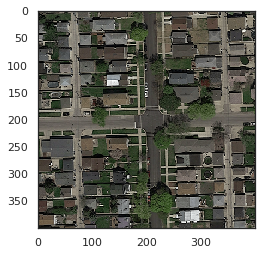

In [7]:
img = x_train[0]
plt.imshow(img)

In [8]:
type(img)

numpy.ndarray

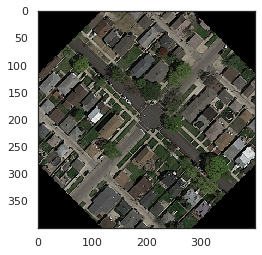

In [9]:
rotated = np.asarray(PIL.Image.fromarray(np.uint8(img * 255)).rotate(45)).astype('float32')/255.0

plt.imshow(rotated)

/home/szhang/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/szhang/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


TRAIN class 0 (background) : 0.0 and class 1 (road) :0.0
VALIDATION class 0 (background) : 0.5 and class 1 (road) :0.5
train size 85
validation size 250


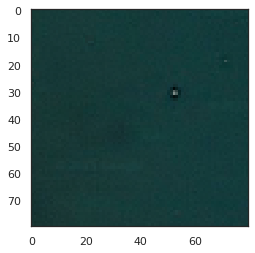

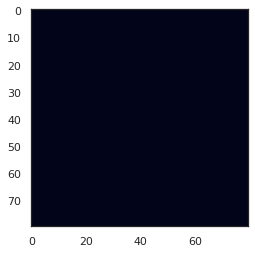

In [39]:
if IS_SUBMISSION:
    x_train = data
    y_train = labels
else:
    # from sklearn.model_selection import StratifiedShuffleSplit
    # 
    # sss = StratifiedShuffleSplit(n_splits=1, test_size=1 - TRAIN_SIZE, random_state=0)
    # 
    # sss.split(data, labels)
    # train_index, test_index = next(iter(sss.split(data, labels)))
    # 
    # x_train, x_test = data[train_index], data[test_index]
    # y_train, y_test = labels[train_index], labels[test_index]
    
    # total_c0 = np.mean(labels == [1, 0])
    # total_c1 = np.mean(labels == [0, 1])
    # print(f'ORIGINAL class 0 (background) : {total_c0} and class 1 (road) :{total_c1}')
    total_train_c0 = np.mean(y_train == [1, 0])
    total_train_c1 = np.mean(y_train == [0, 1])
    print(f'TRAIN class 0 (background) : {total_train_c0} and class 1 (road) :{total_train_c1}')
    
    total_test_c0 = np.mean(y_test == [1, 0])
    total_test_c1 = np.mean(y_test == [0, 1])
    print(f'VALIDATION class 0 (background) : {total_test_c0} and class 1 (road) :{total_test_c1}')
    
    # print(f"original size {len(labels)}")
    print(f"train size {len(y_train)}")
    print(f"validation size {len(y_test)}")
    
    plt.imshow(x_test[1])
    plt.show()
    plt.imshow(np.squeeze(y_test[1], axis=2))
    plt.show()
    


In [11]:
# one whole image 
def get_prediction_to_img(img, model, width, height):
    extra_width = img.shape[1]%width
    extra_height = img.shape[0]%height

    if extra_height or extra_width:
        
        pad_size_width = width - extra_width
        pad_size_height = height - extra_height
        data = np.array(img_crop_base(np.pad(img, ((0, pad_size_height), (0, pad_size_width), (0, 0))), 
                                        width, 
                                        height))
        total_width = img.shape[1] + pad_size_width
        total_height = img.shape[0] + pad_size_height

    else:
        data = np.array(img_crop_base(img, 
                                        width, 
                                        height))
        total_width = img.shape[1]
        total_height = img.shape[0]
        
    element_per_line = total_width//width
    element_per_column = total_height//height
    predict = model.predict(data)
    output_prediction = ((predict > 0.5) * 1).astype(np.uint8)
    
    img_pred = np.empty((total_height, total_width))
    for i in range(0, element_per_line):
        for j in range(0, element_per_column):
            
            img_pred[i*height:(i+1)*height, j*width:(j+1)*width] = np.squeeze(output_prediction[i * element_per_line + j], 
                                                                              axis=2)

    if extra_height or extra_width:
        img_pred = img_pred[:img.shape[0], :img.shape[1]]
        
    return img_pred


def get_prediction(img, model, width, height):
    data = np.asarray(img_crop_base(img, width, height))
    # data_node = tf.constant(data)
    # output = tf.nn.softmax(model(data_node))
    output_prediction = model.predict(data)
    # output_prediction = np.argmax(output_prediction, axis=1)
    # output_prediction = s.run(output)

    return output_prediction


def get_prediction_concat(filename, image_idx, model, width, height):
    imageid = "satImage_%.3d" % image_idx
    image_filename = filename + imageid + ".png"
    img = mpimg.imread(image_filename)

    img_prediction = get_prediction_to_img(img, model, width, height)
    cimg = concatenate_images(img, img_prediction)

    return cimg


def get_testing_prediction(filename, image_idx, model, width, height):
    imageid = "test_%i/test_%i" % (image_idx, image_idx)
    image_filename = filename + imageid + ".png"
    img = mpimg.imread(image_filename)
    cimg = get_prediction_to_img(img, model, width, height)

    return img_float_to_uint8(cimg)


# Get a concatenation of the prediction and groundtruth for given input file
def get_testing_prediction_overlay(filename, image_idx, model, width, height):
    imageid = "test_%i/test_%i" % (image_idx, image_idx)
    image_filename = filename + imageid + ".png"
    img = mpimg.imread(image_filename)
    cimg = get_prediction_to_img(img, model, width, height)
    oimg = make_img_overlay(img, cimg)

    return img_float_to_uint8(oimg)


# Get prediction overlaid on the original image for given input file
def get_prediction_with_overlay(filename, image_idx, model, width, height):
    imageid = "satImage_%.3d" % image_idx
    image_filename = filename + imageid + ".png"
    img = mpimg.imread(image_filename)

    img_prediction = get_prediction_to_img(img, model, width, height)
    oimg = make_img_overlay(img, img_prediction)

    return oimg


# Get prediction overlaid on the original image for given input file
def get_prediction_with_overlay_correctness(filename, gt_filename, image_idx, model, width, height):
    imageid = "satImage_%.3d" % image_idx
    image_filename = filename + imageid + ".png"
    img = mpimg.imread(image_filename)

    imageid = "satImage_%.3d" % image_idx
    gt_image_filename = gt_filename + imageid + ".png"
    gt_img = mpimg.imread(gt_image_filename)
    # gt_labels = np.array([value_to_class_value(np.mean(patch)) for patch in img_crop_base(gt_img, width, height)])
    # gt_labels_img = label_to_img(img.shape[0], img.shape[1], IMG_PATCH_SIZE, IMG_PATCH_SIZE, gt_labels)
    img_prediction = get_prediction_to_img(img, model, width, height)
    oimg = make_img_overlay_gt_pred(img, gt_img, img_prediction)

    return oimg


In [12]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                                patience=3, 
                                                verbose=1, 
                                                factor=0.5, 
                                                epsilon=0.0001,
                                                min_lr=0)

/home/szhang/anaconda3/envs/py37/lib/python3.7/site-packages/keras/callbacks/callbacks.py:998: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [13]:
early_stop_callback = EarlyStopping(monitor='acc', min_delta=0.0001, patience=11, verbose=1, mode='auto')

In [14]:
def get_custom_nn(input_shape):
    inputs = Input(input_shape)
    
    conv1 = Conv2D(16, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(16, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    drop1 = Dropout(0.25)(pool1)
    conv2 = Conv2D(32, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer='he_normal')(drop1)
    conv2 = Conv2D(32, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    drop2 = Dropout(0.25)(pool2)
    conv3 = Conv2D(64, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer='he_normal')(drop2)
    conv3 = Conv2D(64, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    drop3 = Dropout(0.25)(pool3)
    conv4 = Conv2D(128, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer='he_normal')(drop3)
    conv4 = Conv2D(128, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
#     pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

#     conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
#     conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    #drop5 = Dropout(0.5)(conv4)

    up6 = Conv2D(128, kernel_size=(2,2), activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(drop4))
    merge6 = concatenate([conv3,up6], axis=3)
    conv6 = Conv2D(64, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(64, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
    drop6 = Dropout(0.25)(conv6)
    up7 = Conv2D(64, kernel_size=(2,2), activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(drop6))
    merge7 = concatenate([conv2,up7], axis=3)
    conv7 = Conv2D(32,kernel_size=(3,3), activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(32,kernel_size=(3,3), activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
    drop7 = Dropout(0.25)(conv7)
    up8 = Conv2D(32, kernel_size=(2,2), activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(drop7))
    merge8 = concatenate([conv1,up8], axis=3)
    conv8 = Conv2D(16, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(16, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
    drop8 = Dropout(0.5)(conv8)
    
    conv10 = Conv2D(1, kernel_size=(1,1), activation = 'sigmoid')(drop8)

    model = Model(input = inputs, output = conv10)    
    
    return model

In [15]:
if LOAD_MODEL_NAME:
    model = load_model(LOAD_MODEL_NAME)
else:
    #define what is the output
    model = get_unet(input_shape=input_shape)

    optimizer = Adam(0.001)
    model.compile(optimizer = optimizer , loss = "binary_crossentropy", metrics=["acc"])


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 80, 80, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 80, 80, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 80, 80, 16)   2320        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 40, 40, 16)   0           conv2d_2[0][0]                   
____________________________________________________________________________________________

/home/szhang/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


In [16]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 80, 80, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 80, 80, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 80, 80, 16)   2320        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 40, 40, 16)   0           conv2d_2[0][0]                   
____________________________________________________________________________________________

Callback for computing F1 score on global validation set, as f1 metric does not exist 

In [17]:
global_f1s = GlobalF1OneToOne()

In [18]:
epochs = 100 # small dataset, so we can afford greater number of epochs
batch_size = 100 # small dataset, small batch_size

In [19]:
steps_per_epoch=x_train.shape[0]*10
print(f'steps per epoch {steps_per_epoch}')
a, b = next(iter(image_generator.generate_batches(x_train, y_train, batch_size=batch_size)))

steps per epoch 850


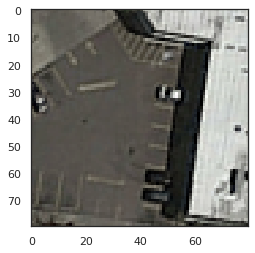

In [20]:
plt.imshow(a[0])

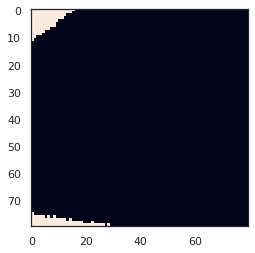

In [21]:
# print(b[1, :, :, 1].shape)
plt.imshow(np.squeeze(b[0], axis=2))

In [22]:
# plt.imshow(x_test[0])

catch keyboard interrupt to not throw away the model that is being trained if run in a script
and set random seed before data model training for reproductibility purpose

In [23]:
np.random.seed(0)
begin = time.time()
try:

    if IS_SUBMISSION:
        history = model.fit_generator(image_generator.generate_batches(x_train, y_train, batch_size=batch_size),
                              epochs = epochs, 
                              verbose = 2, 
                              steps_per_epoch=steps_per_epoch, 
                              callbacks=[learning_rate_reduction, early_stop_callback])
    else:
        history = model.fit_generator(image_generator.generate_batches(x_train, y_train, batch_size=batch_size),
                      epochs = epochs, 
                      validation_data = (x_test, y_test),
                      verbose = 2, 
                      steps_per_epoch=steps_per_epoch, 
                      callbacks=[learning_rate_reduction, early_stop_callback, global_f1s])

except KeyboardInterrupt:
# Do not throw away the model in case the user stops the training process
    pass
end = time.time()
print(f"Total training time : {end - begin}")

Epoch 1/100
 - 266s - loss: 0.3425 - acc: 0.8473 - val_loss: 0.3423 - val_acc: 0.8522
F1 score on validation set 0.0
Epoch 2/100
 - 261s - loss: 0.2207 - acc: 0.9050 - val_loss: 0.5406 - val_acc: 0.8217
F1 score on validation set 0.0
Epoch 3/100
 - 261s - loss: 0.1892 - acc: 0.9214 - val_loss: 0.6268 - val_acc: 0.8157
F1 score on validation set 0.0
Epoch 4/100
 - 261s - loss: 0.1748 - acc: 0.9274 - val_loss: 0.7184 - val_acc: 0.8275
F1 score on validation set 0.0
Epoch 5/100
 - 261s - loss: 0.1649 - acc: 0.9317 - val_loss: 0.7261 - val_acc: 0.8131
F1 score on validation set 0.0
Epoch 6/100
 - 261s - loss: 0.1570 - acc: 0.9348 - val_loss: 0.7627 - val_acc: 0.8259
F1 score on validation set 0.0
Epoch 7/100
 - 260s - loss: 0.1493 - acc: 0.9379 - val_loss: 0.8987 - val_acc: 0.8057
F1 score on validation set 0.0
Epoch 8/100
 - 261s - loss: 0.1461 - acc: 0.9397 - val_loss: 0.8403 - val_acc: 0.8099
F1 score on validation set 0.0
Epoch 9/100
 - 261s - loss: 0.1395 - acc: 0.9456 - val_loss: 0.6

/home/szhang/anaconda3/envs/py37/lib/python3.7/site-packages/keras/callbacks/callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_accuracy` which is not available. Available metrics are: val_loss,val_acc,loss,acc,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/home/szhang/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


<module 'time' (built-in)>
val acc :  0.8146560364961624


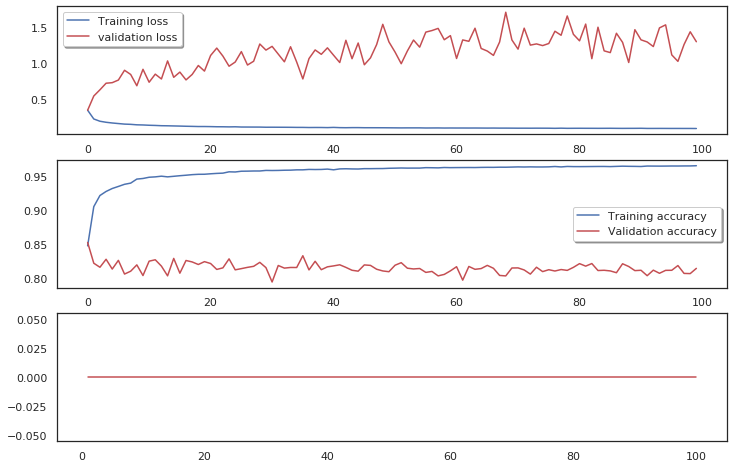

In [24]:
def print_history(history, f1s):
    print(time)
    fig, ax = plt.subplots(3,1, figsize=(12, 8))
    ax[0].plot(history.history['loss'], color='b', label="Training loss")
    ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
    legend = ax[0].legend(loc='best', shadow=True)

    ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
    ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
    legend = ax[1].legend(loc='best', shadow=True)
    print("val acc : ", np.mean(history.history['val_acc']))
    
    ax[2].plot(range(1, len(f1s) + 1), f1s, color='r',label="Validation F1 score")
    
if not IS_SUBMISSION:
    print_history(history, global_f1s.f1s)

save ENTIRE model (nn architecture, weights, state of optimizer)
with given prefix name appended with its version number, if conflict, try then next number for automation purpose

In [25]:
if SAVE_TRAINED_MODEL:
    def save_model(model: Model, name, directory="pretrained_cnn/models"):
        new_filename = f"{directory}/{name}_0.hdf5"
        files = glob.glob(f"{directory}/{name}*.hdf5")
        if new_filename in files:
            reg_num = re.compile("\d+")
            last_num = max([int(reg_num.findall(file)[0]) for file in files if reg_num.search(file)])
            next_num = last_num + 1
            new_filename = f"{directory}/{name}_{next_num}.hdf5"
    
        model.save(new_filename)
    save_model(model, MODEL_NAME, SAVED_MODEL_DIR)

In [26]:
if not IS_SUBMISSION :
    predict = np.asarray(model.predict(x_test))
    predicts = (predict.reshape(-1) > ROAD_THRESHOLD) * 1
    print(np.max(predicts))
    targ = y_test
    targ = (targ.reshape(-1) > ROAD_THRESHOLD) * 1
    print(np.max(targ))

    print(f1_score(targ, predicts))

1
0
0.0


In [27]:
if not IS_SUBMISSION:
    TRAIN_SIZE = 0.9
    train_nb = int(100 * TRAIN_SIZE)
    # val_nb = 100 - train_nb
    x_test = extract_data_base(train_data_filename, range(train_nb + 1, 100 + 1), WIDTH, HEIGHT)
    y_test = extract_labels_base(train_labels_filename, range(train_nb + 1, 100 + 1), WIDTH, HEIGHT)
    # x_test = extract_data(train_data_filename, range(train_nb + 1, 100 + 1), image_generator_padding=image_generator)
    # y_test = extract_labels(train_labels_filename, range(train_nb + 1, 100 + 1))

Finish loading all images
Finish loading all images


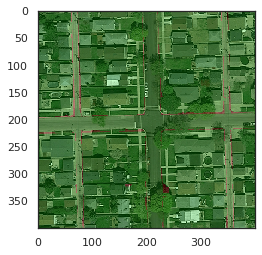

In [28]:
# check prediction correctness on one training picture

# pimg_train = get_prediction_concat(train_data_filename, 1, model)
pimg_train = get_prediction_with_overlay_correctness(train_data_filename, train_labels_filename, 1, model, WIDTH, HEIGHT)
plt.imshow(pimg_train)

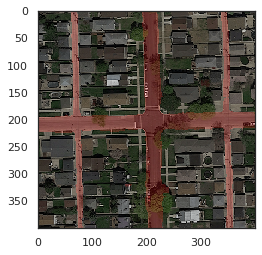

In [29]:
# training picture road prediction overlay
oimg = get_prediction_with_overlay(train_data_filename, 1, model, WIDTH, HEIGHT)
plt.imshow(oimg)


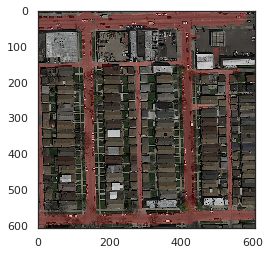

In [30]:
# test picture prediction overlay
pimg_test = get_testing_prediction_overlay(test_data_filename, 1, model, WIDTH, HEIGHT)
plt.imshow(pimg_test)

In [31]:
prediction_training_dir = "../data/tf_tmp/predictions_training/"
prediction_testing_dir = "../data/tf_tmp/predictions_testing/"
prediction_testing_overlay_dir = "../data/tf_tmp/predictions_testing_overlay/"

In [32]:

if IS_SUBMISSION:
# if True:
    
    TRAINING_SIZE = 100
    
    print("Running prediction on training set")
    if not os.path.isdir(prediction_training_dir):
        os.mkdir(prediction_training_dir)
    for i in range(1, TRAINING_SIZE + 1):
        pimg = get_prediction_concat(train_data_filename, i, model, WIDTH, HEIGHT)
        Image.fromarray(pimg).save(prediction_training_dir + "prediction_" + str(i) + ".png")
        # oimg = get_prediction_with_overlay(train_data_filename, i, model)
        
        oimg = get_prediction_with_overlay_correctness(train_data_filename, train_labels_filename, i, model, WIDTH, HEIGHT)
        oimg.save(prediction_training_dir + "overlay_" + str(i) + ".png")

In [33]:
# if IS_SUBMISSION:
if True:
    print("Running prediction on testing set")
    if not os.path.isdir(prediction_testing_dir):
        os.mkdir(prediction_testing_dir)
    for i in range(1, 51):
        pimg = get_testing_prediction(test_data_filename, i, model, WIDTH, HEIGHT)
        Image.fromarray(pimg).save(prediction_testing_dir + "prediction_" + "%.3d" % i + ".png")
        
        oimg = get_testing_prediction_overlay(test_data_filename, i, model, WIDTH, HEIGHT)
        Image.fromarray(oimg).save(prediction_testing_overlay_dir + "prediction_overlay" + "%.3d" % i + ".png")

Running prediction on testing set
